In [1]:
import cv2 as cv
import os
import shutil
import numpy as np
from matplotlib import pyplot as plt

39


(-0.5, 575.5, 323.5, -0.5)

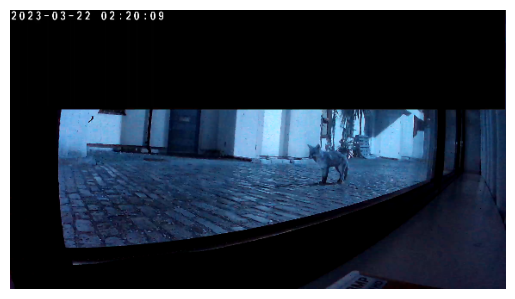

In [2]:
# Extracts frames from given video, taking a frame every n milliseconds
def extract_frames(video_path, interval):
    video = cv.VideoCapture(video_path)
    
    frames = []
    success, frame = video.read()
    total_frames = video.get(cv.CAP_PROP_FRAME_COUNT)
    i = 0
    while success and video.get(cv.CAP_PROP_POS_FRAMES) < total_frames:
        frames.append(cv.resize(frame, (576, 324)))
        assert i < 500, "Maximum number of frames exceeded"
        video.set(cv.CAP_PROP_POS_MSEC, i * interval)
        success, frame = video.read()
        i += 1
    return frames

# Simple test
frames = extract_frames('sample_videos/cool_fox.mp4', 250)
print(len(frames))
plt.imshow(frames[0])
plt.axis('off')

0.0
193.7


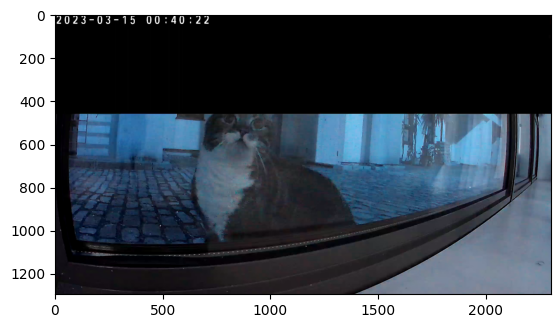

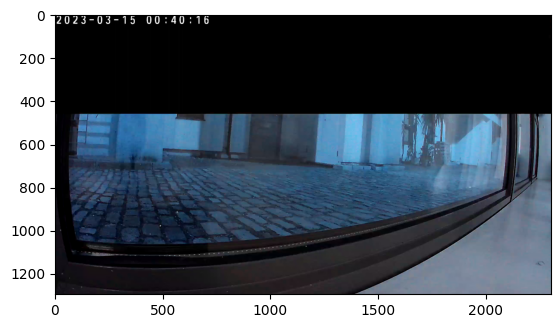

In [3]:
# Mean squared error between 2 frames
def mse(frame1, frame2):
    # Cast uint8 to int32 to avoid overflow
    frame1 = frame1.astype(np.int32)
    frame2 = frame2.astype(np.int32)

    assert frame1.shape == frame2.shape, "Shapes do not match"

    squared_error = (frame1 - frame2) ** 2
    return np.mean(squared_error)

# Simple test
img1 = cv.imread("sample_frames/cool_cat.png")
img2 = cv.imread("sample_frames/no_cool_cat.png")
print(mse(img1, img1)) # Should be 0
print(round(mse(img1, img2), 2)) # Should not be 0
plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()

In [4]:
# Returns all frames that have a MSE higher than threshold when compared to reference frame
def pick_frames_threshold(frames, reference_frame, threshold):
    picked_frames = [frame for frame in frames if mse(frame, reference_frame) > threshold]
    return picked_frames

# Saves frame if its MSE with ref. frame exceeds threshold, then copies it to ref. frame
# Does not include first and last 4 frames
def pick_frames_sliding(frames, threshold):
    reference_frame = frames[0]
    picked_frames = []
    for frame in frames:
        if mse(frame, reference_frame) > threshold:
            # Save the current frame and overwrite ref. frame
            reference_frame = frame
            picked_frames.append(frame)
    return picked_frames[4:-4]

# Simple test
frames = extract_frames('sample_videos/cool_fox.mp4', 250)
threshold_sample = pick_frames_threshold(frames, frames[0], 100)
sliding_sample = pick_frames_sliding(frames, 20)
print(len(threshold_sample), len(sliding_sample))

2 12


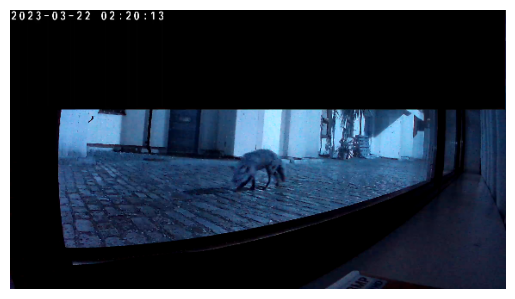

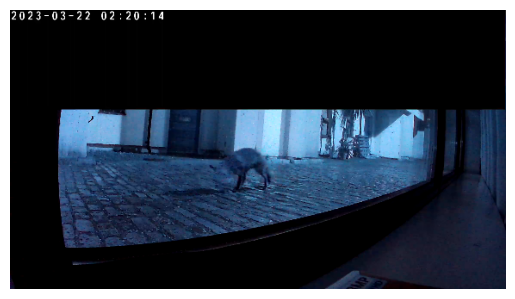

In [5]:
for img in threshold_sample:
    plt.imshow(img)
    plt.axis('off')
    plt.show()

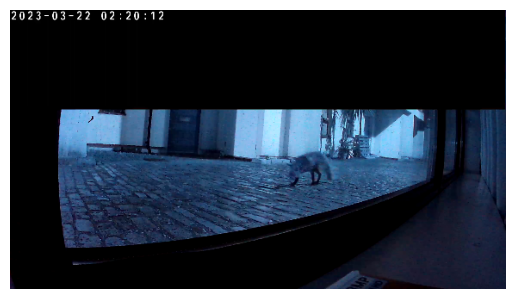

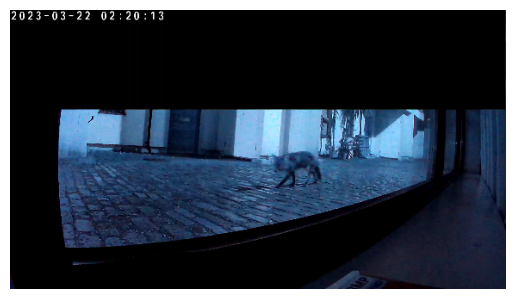

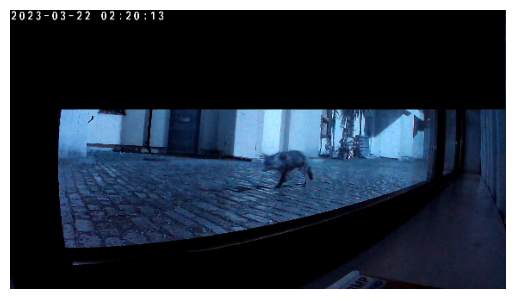

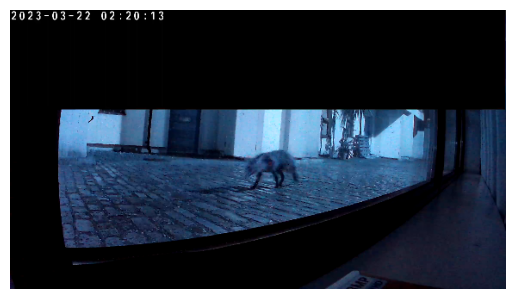

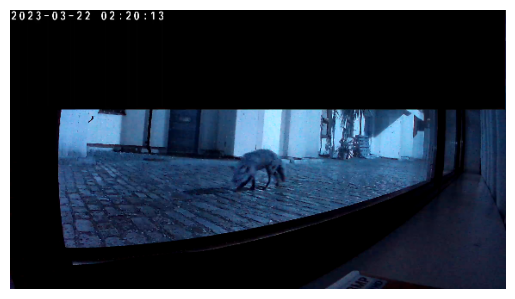

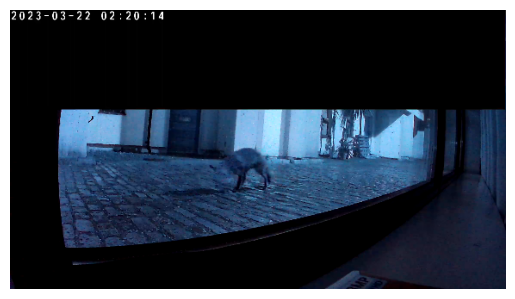

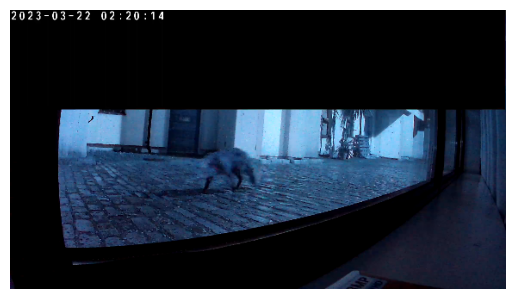

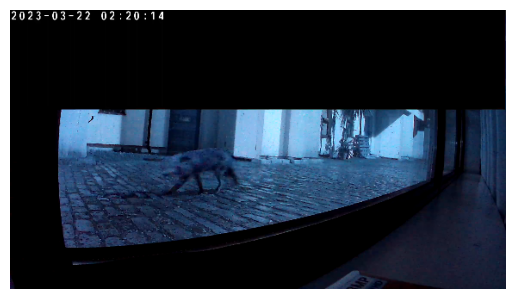

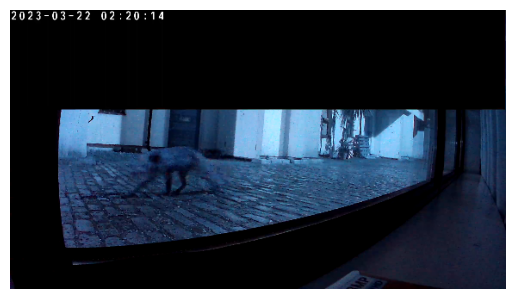

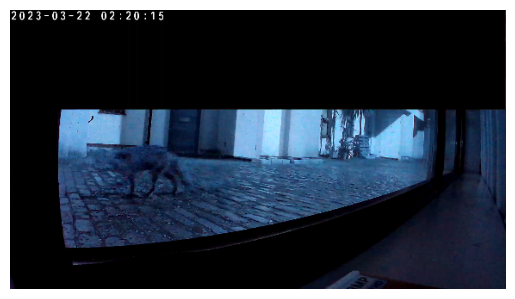

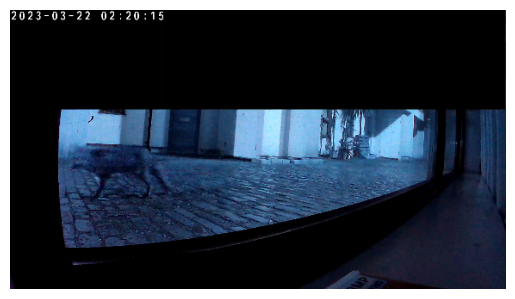

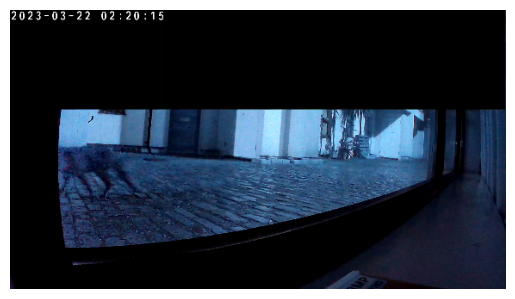

In [6]:
for img in sliding_sample:
    plt.imshow(img)
    plt.axis('off')
    plt.show()

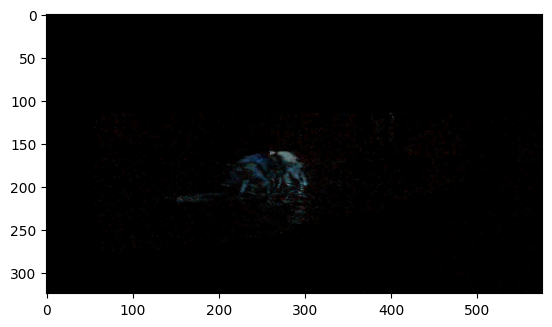

In [13]:
def show_difference(img1, img2):
    assert img1.shape == img2.shape, "Shapes do not match"
    diff = np.abs(np.subtract(img1, img2, dtype=np.int32))
    plt.imshow(diff)
    plt.show()

show_difference(frames[21], frames[22])

Experiments with denoising

MSE between empty images: 30.33 
MSE between empty and a cat: 100.89 
difference: 108 %


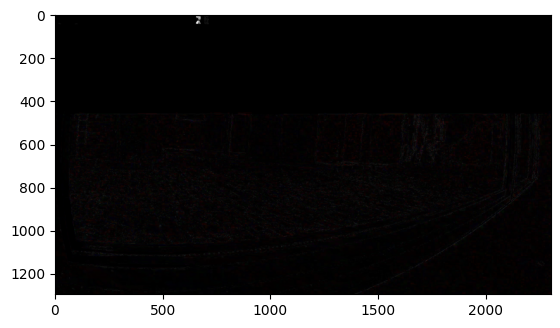

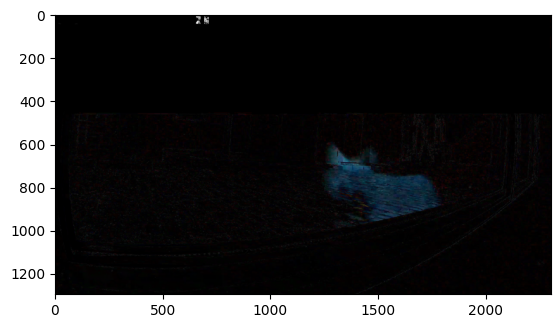

In [655]:
# Compares difference between sample images, using given function on images
def test_denoising(func, *args, **kwargs):
    # Load sample images
    empty1 = func(cv.imread('sample_noise/empty1.png'), *args, **kwargs)
    empty2 = func(cv.imread('sample_noise/empty2.png'), *args, **kwargs)
    cat = func(cv.imread('sample_noise/cat.png'), *args, **kwargs)

    # Calculate MSE between pairs of images
    mse_empty = round(mse(empty1, empty2), 2)
    mse_cat = round(mse(empty1, cat), 2)
    mse_difference = round(abs(mse_cat - mse_empty) / (mse_cat + mse_empty) * 200)

    # Show results
    print('MSE between empty images:', mse_empty, 
          '\nMSE between empty and a cat:', mse_cat, 
          '\ndifference:', mse_difference, '%')
    
    # Visualising the difference
    show_difference(empty1, empty2)
    show_difference(empty1, cat)
    
test_denoising(lambda x: x) # Using identity function

MSE between empty images: 13.83 
MSE between empty and a cat: 79.17 
difference: 141 %


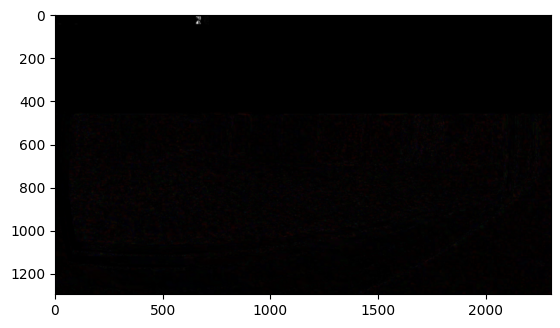

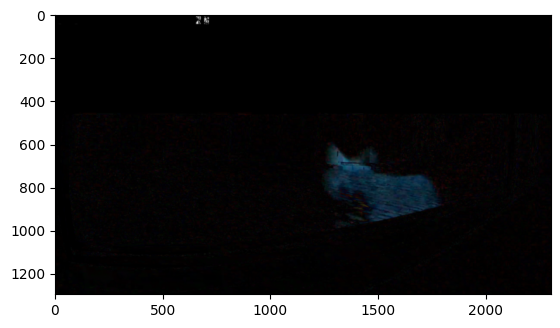

In [656]:
test_denoising(cv.blur, (6, 6))

MSE between empty images: 11.72 
MSE between empty and a cat: 78.07 
difference: 148 %


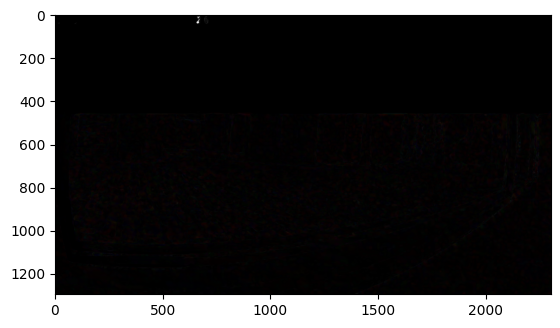

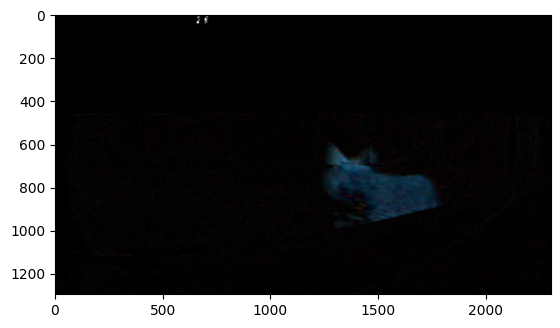

In [657]:
test_denoising(cv.medianBlur, 13)

MSE between empty images: 12.72 
MSE between empty and a cat: 77.44 
difference: 144 %


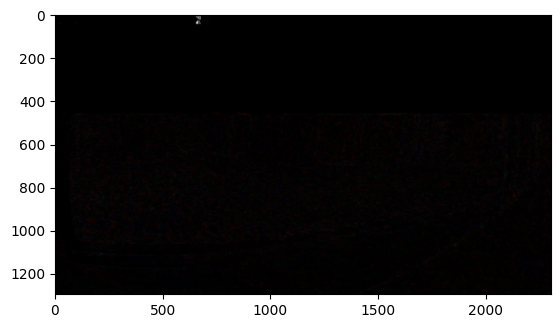

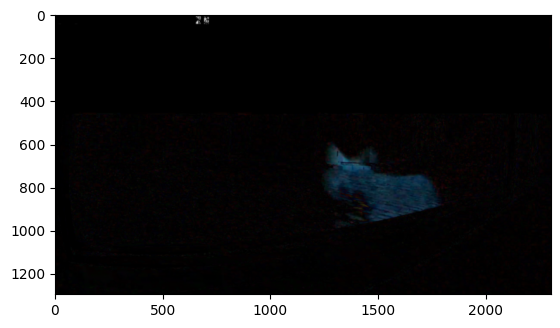

In [658]:
test_denoising(cv.GaussianBlur, ksize=(13, 13), sigmaX=2, sigmaY=2)

Locating the moving object

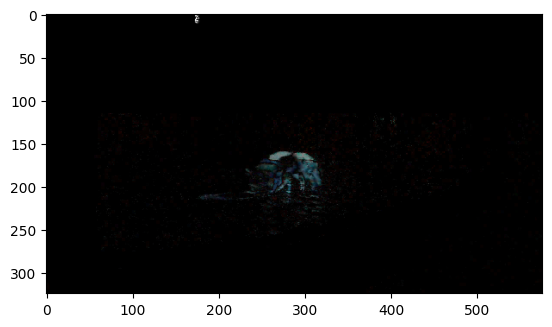

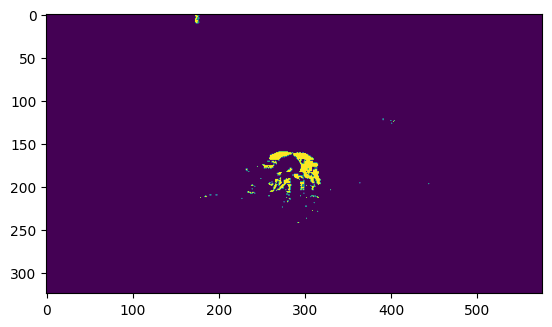

False

In [837]:
# Calculates sum of RGB for each pixel. If higher than
# threshold, makes the pixel white, otherwise black,
# thus converting image to binary image
def to_binary(img, threshold):
    binary_image = np.sum(img, axis=2) > threshold
    return binary_image

diff = abs(frames[20].astype(np.int32) - frames[21].astype(np.int32))
bin = to_binary(diff, 120)
plt.imshow(diff)
plt.show()
plt.imshow(bin)
plt.show()

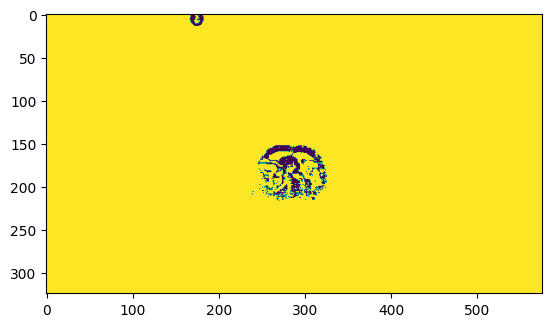

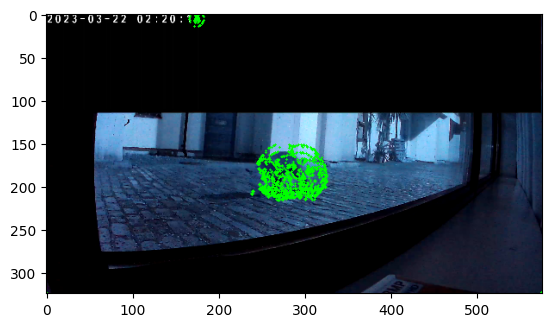

{'m00': 36.0, 'm10': 6294.5, 'm01': 229.0, 'm20': 1100628.1666666665, 'm11': 40028.0, 'm02': 1762.0, 'm30': 192460078.25, 'm21': 6997055.083333333, 'm12': 307953.0833333333, 'm03': 14863.5, 'mu20': 52.32638888875954, 'mu11': -12.01388888888323, 'mu02': 305.30555555555566, 'mu30': 2.3613041043281555, 'mu21': 38.21334876617442, 'mu12': 25.12114197527262, 'mu03': -228.94290123456813, 'nu20': 0.040375300068487295, 'nu11': -0.009269975994508664, 'nu02': 0.23557527434842257, 'nu30': 0.00030366565127676895, 'nu21': 0.004914268102645887, 'nu12': 0.0032305995338570755, 'nu03': -0.029442245529136844}


In [829]:
th3 = cv.adaptiveThreshold(cv.cvtColor(np.uint8(diff), cv.COLOR_BGR2GRAY),255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,41,11)
plt.imshow(th3)
plt.show()

contours, _ = cv.findContours(th3, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
copy = np.copy(frames[21])

# Iterate over the contours
for contour in contours:
    # Filter or process the contour as needed
    # For example, you can calculate the contour area using cv2.contourArea(contour)
    # or fit a bounding rectangle using cv2.boundingRect(contour)
    
    # Draw the contour on the original image (for visualization purposes)

    cv.drawContours(copy, contour, -1, (0, 255, 0), 2)

plt.imshow(copy)
plt.show()
print(cv.moments(contours[0]))

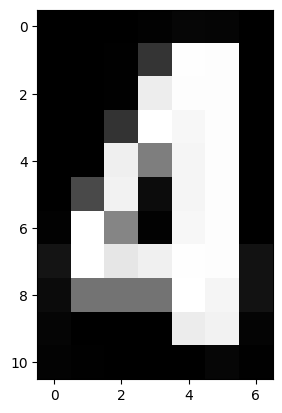

In [830]:
rectangular_contour = contours[0]  # Replace with the desired contour

# Extract the bounding rectangle coordinates
x, y, width, height = cv.boundingRect(rectangular_contour)

# Extract the region of interest (ROI) from the original image
roi = frames[21][y:y+height, x:x+width]

# Save the ROI as a new image
plt.imshow(roi)

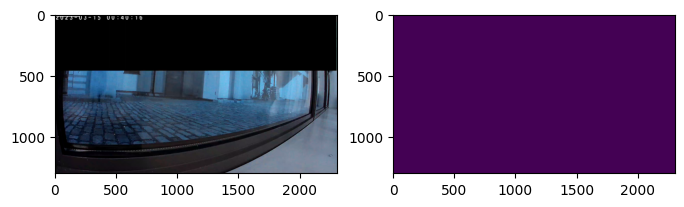

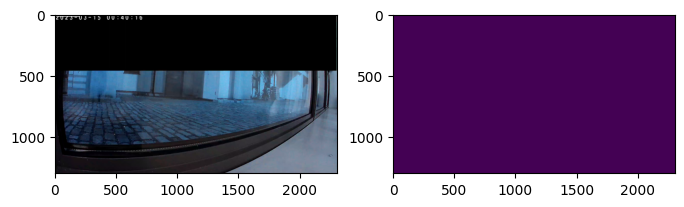

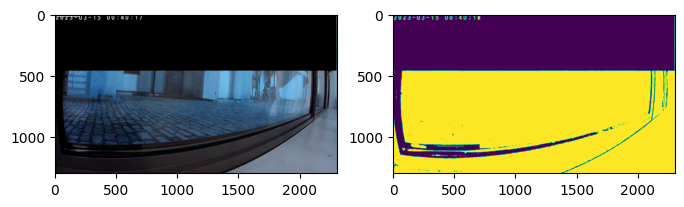

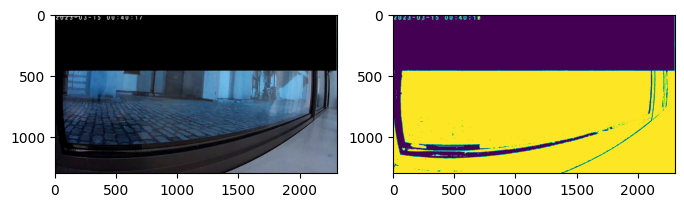

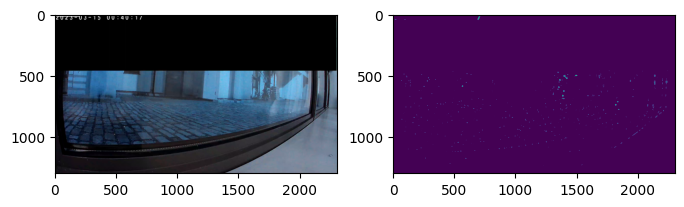

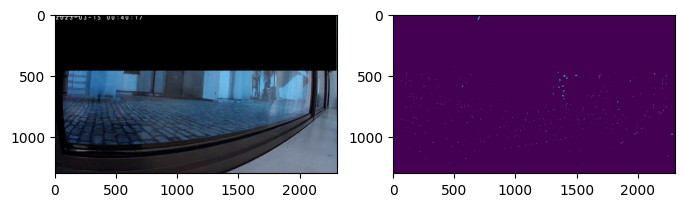

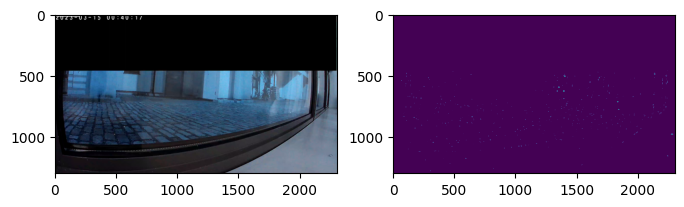

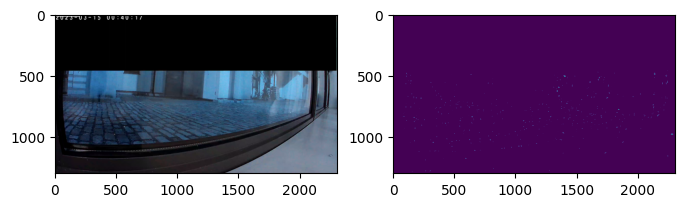

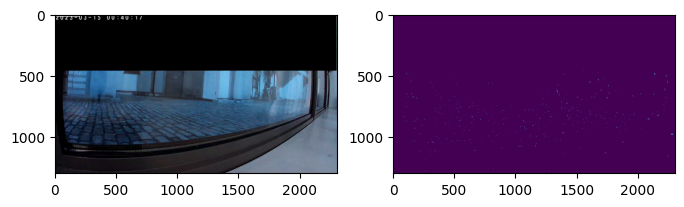

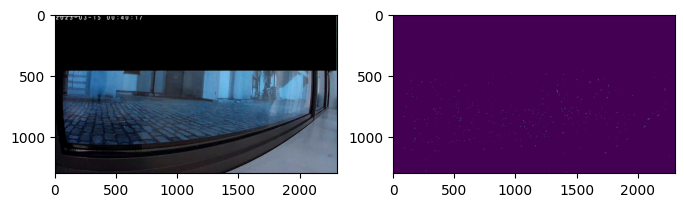

KeyboardInterrupt: 

In [793]:
backSub = cv.createBackgroundSubtractorKNN()
capture = cv.VideoCapture("sample_videos/cool_cat.mp4")
while True:
    ret, frame = capture.read()
    if frame is None:
        break
    
    fgMask = backSub.apply(frame)
    
    
    cv.rectangle(frame, (10, 2), (100,20), (255,255,255), -1)
    cv.putText(frame, str(capture.get(cv.CAP_PROP_POS_FRAMES)), (15, 15),
               cv.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))
    
    fig = plt.figure(figsize=(8, 8))
    fig.add_subplot(1, 2, 1)
    plt.imshow(frame)

    fig.add_subplot(1, 2, 2)
    plt.imshow(fgMask)

    plt.show()

In [ ]:
# Calculates sum of RGB for each pixel. If higher than
# threshold, makes the pixel white, otherwise black,
# thus converting image to binary image
def to_binary(img, threshold):
    binary_image = np.sum(img, axis=2) > threshold
    return binary_image

diff = abs(frames[20].astype(np.int32) - frames[21].astype(np.int32))
bin = to_binary(diff, 120)
plt.imshow(diff)
plt.show()
plt.imshow(bin)
plt.show()